In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from utils.utils import _down_cast
from utils.utils import ensemble_submissions_uncertainty
from utils.configure_logger import configure_logger
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [6]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION 
SALES_VALIDATION = constants.SALES_VALIDATION
CALENDAR = constants.CALENDAR 
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION 
SELL_PRICES = constants.SELL_PRICES

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES 

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [7]:
# all groups: seasonal, auto, autoquantiles, momentum
SPARSE_FEATURES = [
    'autoquantiles_sold_ma_28_0.5', 'auto_sold_ma_28', 'auto_sold_ma_168', 'autoquantiles_sold_ma_168_0.165','autoquantiles_sold_ma_168_0.835',
]
SPARSE_FEATURES += [f'seasonal_weekday_{i}' for i in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
SPARSE_FEATURES += [f'seasonal_monthday_{i}' for i in range(1,32)]
SPARSE_FEATURES += [f'seasonal_month_{i}' for i in range(1,13)]
# SPARSE_FEATURES += [f'state_{i}' for i in ['CA', 'TX', 'WI']]

USE_ALL = False
SPARSE_FEATURES = None
PLOT_PREDICTIONS = True

undersampling_dict = {
    # 'Level5': .15,
    # 'Level6': .15,
    # 'Level7': .15,
    # 'Level8': .15,
    # 'Level9': .1,
    'Level10': .001,
    'Level11': .0001,
    'Level12': .00001
}

HIGH_UNDERSAMPLING = True
TEST_NUMBER = 1
TEST_NUMB = 0

ALL_PREFIXES = ['auto_sold_', 'auto_sold_ma', 'auto_sold_std', 'auto_sold_ewm', 'autoquantiles_sold_qtile',
    'price_momentum','seasonal_','seasonal_weekday','seasonal_monthday','seasonal_month',
]

In [17]:
# EXPERIMENT: SEASONALITY FEATURES (>> DONE TILL LEVEL 9, ALL FOLDS)
EXPERIMENTS_DICT = {
    "seasonal": {
        "BASE": [],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['seasonal_weekday','auto_sold_ewm'],
            ['seasonal_monthday','auto_sold_ewm'],
            ['seasonal_weekday','seasonal_monthday','auto_sold_ewm'],
            ['seasonal','auto_sold_ewm'],
        ]
    },
    "ewm vs. ma": {
        "BASE": ['seasonal_'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['auto_sold_ma'],
            ['auto_sold_ewm', 'auto_sold_ma'],
        ]
    },
    "quantiles vs. std": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['auto_sold_qtile'],
            ['auto_sold_std'],
            ['auto_sold_qtile','auto_sold_std'],   
        ]
    },
    "price auto/momentum": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            ['price_auto_std'],
            ['price_momentum'],
            ['price_uncond'],
            ['price_auto_std', 'price_momentum'],
            ['price_auto_std', 'price_momentum', 'price_uncond']
        ]
    },
    "best models": {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm', 'auto_sold_ma', 'auto_sold_qtile', 'auto_sold_std'],
            ['auto_sold_ewm', 'auto_sold_qtile', 'auto_sold_std'],
            ['auto_sold_ma', 'auto_sold_qtile', 'auto_sold_std']
        ]
    },
    'full vs. sparse': {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            [ 'auto_sold_ewm_112', 'auto_sold_ewm_28',
            'auto_sold_qtile_28_0.5', 'auto_sold_ma_28',
            'auto_sold_qtile_28_0.9', 'auto_sold_qtile_28_0.1'
            ],
            ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm']
        ]
    },
}

### Get all options

In [9]:
from utils.utils import load_results_as_json
r = load_results_as_json('../data/uncertainty/all_results.json')
print('All feature combinations:')
list(r.keys())

All feature combinations:


['include_auto_price_seasonal',
 'include_auto_sold_56_auto_sold_14_auto_sold_7_auto_sold_1_auto_sold_2_seasonal_price',
 'include_auto_seasonal',
 'include_auto_seasonal_store_state',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.9',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.9_autoquantiles_sold_qtile_28_0.1',
 'include_seasonal_weekday_seasonal_monthday_seasonal_month_auto_sold_ewm_auto_sold_ma_autoquantiles',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.1',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_a

### Load Models to Visualise Feature Importance

In [52]:
def load_model(experiment_name: str, level: str = 'Level1', fold: int = 1914, quantile=.5):
    base_features = EXPERIMENTS_DICT[experiment_name]['BASE'] 
    exp_features =  EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
    
    res = {}
    for exp_feature in exp_features:
        features = base_features + exp_feature
        print(features)
        agg_columns = AGG_LEVEL_COLUMNS[level]
        if len(agg_columns) == 0:
            agg_columns_str = 'Total_X'
        elif len(agg_columns) == 1:
            agg_columns_str = agg_columns[0] #+ '_X'
        else:
            agg_columns_str = '_'.join(agg_columns)
        import joblib
        try:
            mod = joblib.load(f'../data/uncertainty/fold_{fold}/models/lgb_val_nt_{agg_columns_str}_include_{"_".join(features)}_q={quantile}.joblib')
        except:
            mod = joblib.load(f'../data/uncertainty/fold_{fold}/models/lgb_val_nt_{agg_columns_str}_include_{"_".join(features)}.joblib')
            print('no quantile specific available')
        res[' '.join(features)] = mod
    return res

['seasonal_', 'auto_sold_ewm']
['seasonal_', 'auto_sold_ma']
['seasonal_', 'auto_sold_ewm', 'auto_sold_ma']


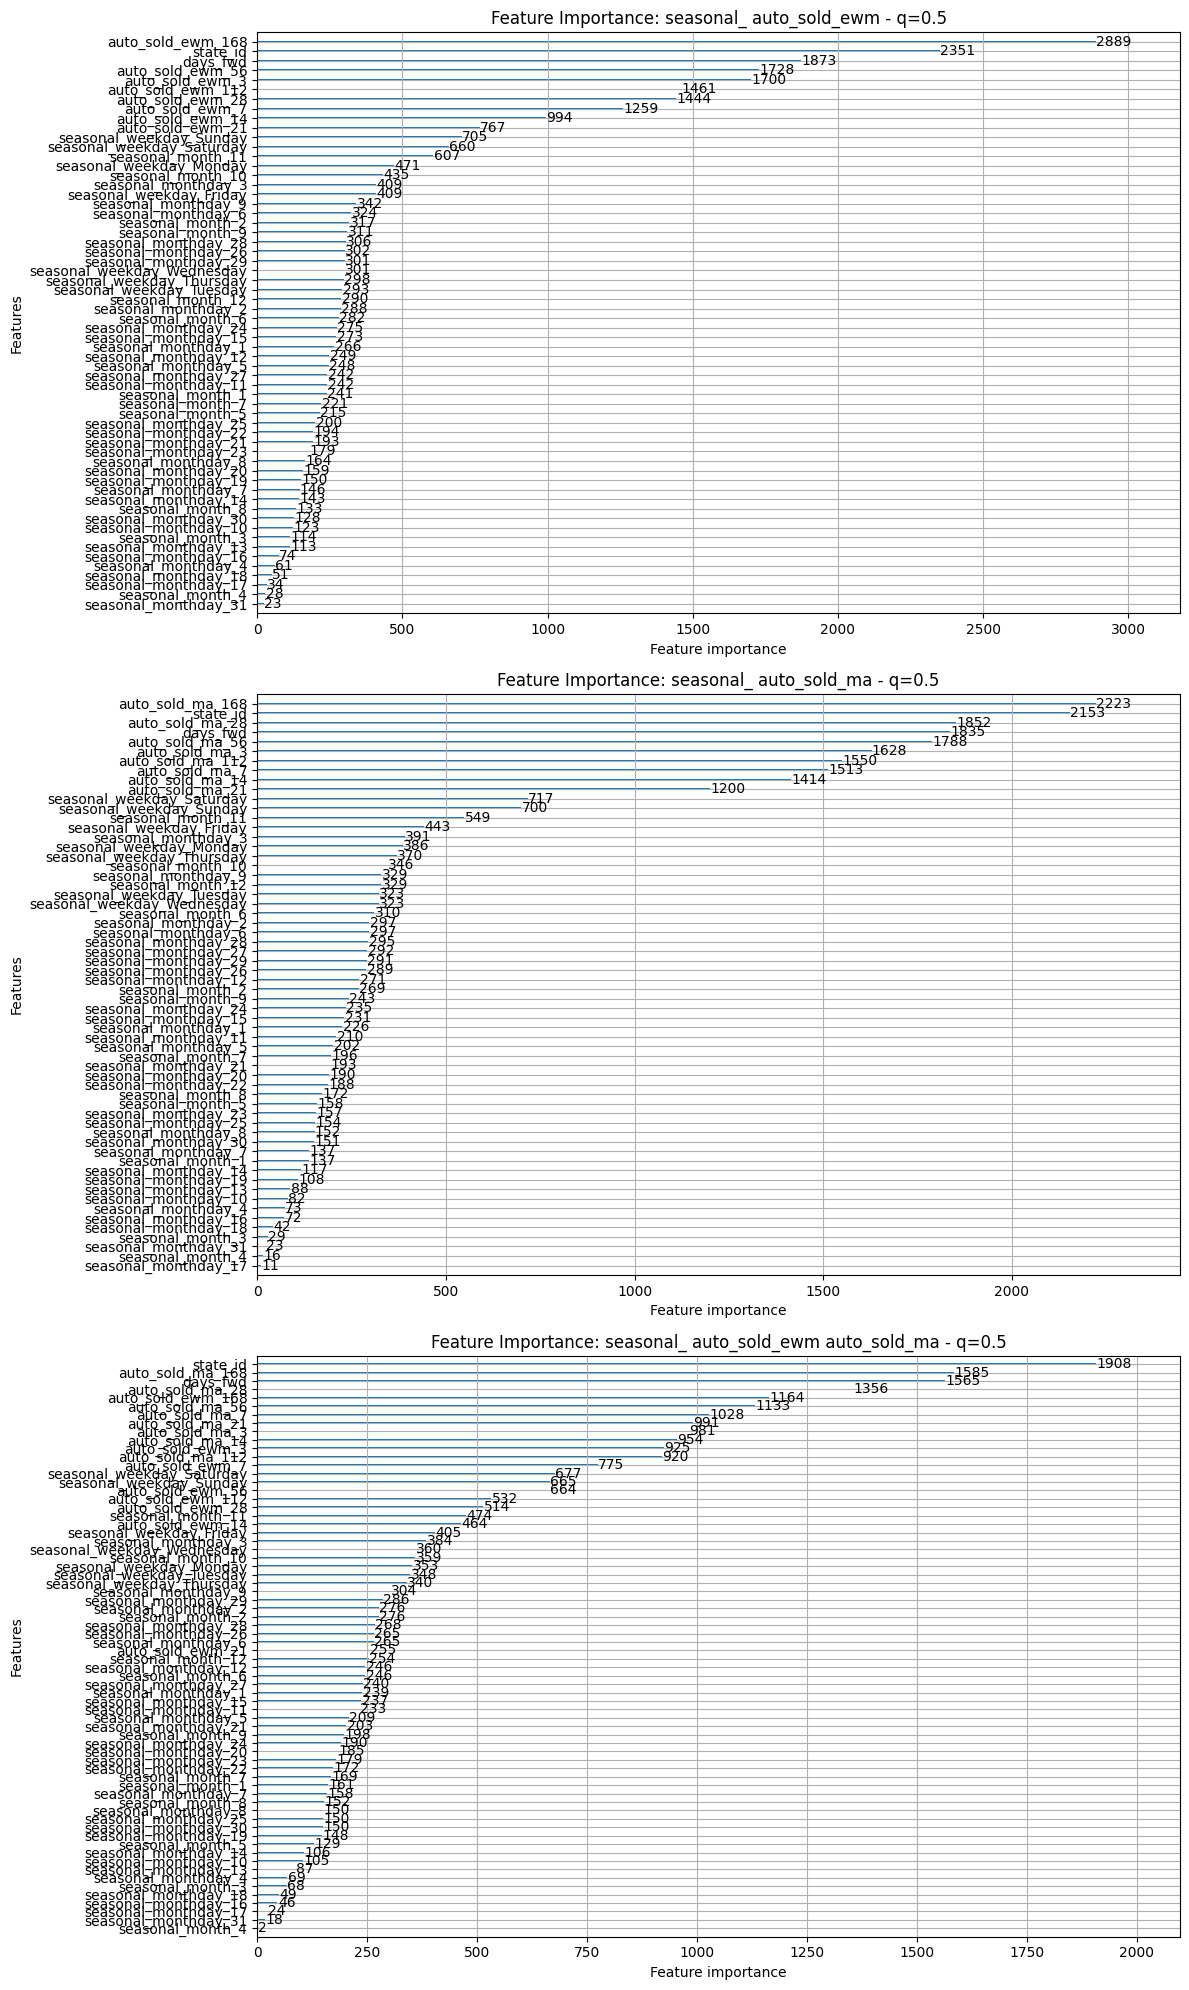

In [61]:
experiment_name = 'quantiles vs. std'
experiment_name = 'best models'
experiment_name = 'full vs. sparse'
experiment_name = 'ewm vs. ma'
level = 'Level2'
fold = 1886
quantile = .5
models = load_model(experiment_name, level, fold, quantile=quantile)
n_models = len(models.values())
# fig, axs = plt.subplots(1,n_models,figsize=(20,12))
fig, axs = plt.subplots(n_models,1,figsize=(12,20))
for i, (key, item) in enumerate(models.items()):
    key: str = key
    ax = axs[i]
    lgb.plot_importance(item, ax = ax)
    ax.set_title(f'Feature Importance: {key} - q={quantile}')
fig.tight_layout()
plt.savefig(f'../figure/results/importance_{experiment_name}_{level}_{fold}.png', dpi=300)
plt.show()

### Load Predictions and Plot Predictions

In [31]:
def read_concat_predictions(fold_name: int, exclude_columns: list = [], include_columns: list = [], use_all = False, load_submissions_path: str = 'temp_submissions/'):
    """
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """

    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path)

    dfs: list = []
    for level in list(AGG_LEVEL_COLUMNS.keys())[:HIGHEST_LEVEL]:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'
        
        file_path = f'../data/uncertainty/fold_{str(fold_name)}/' + load_submissions_path 
        file_path += f'lgb_val_nt_{group_names}_'
        if use_all:
            file_path += f'use_all.csv'  
        elif include_columns == None:
            file_path += f'exclude_{"_".join(exclude_columns)}.csv'            
        elif isinstance(include_columns, list):
            file_path += f'include_{"_".join(include_columns)}.csv'
        
        dfs.append(file_path)
    return ensemble_submissions_uncertainty(dfs)

In [11]:
# these variables are used later on
FORCE_RELOAD = False
try:
    # simple code to check if variable exists
    d_int + 1
    if FORCE_RELOAD:
        raise Exception()
except:
    # if not, load again
    # takes about 2-3 minutes to reload and parse
    d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
    d_int = pd.read_parquet('../data/uncertainty/cv_template/temp_d_int.parquet')['d_int']
    # d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))
    # d_int.to_frame('d_int').to_parquet('../data/uncertainty/cv_template/temp_d_int.parquet', index = False)
    d['d_int'] = d_int

In [32]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='right',
        on=['id_merge', 'd']
    )

    # for c in ['sold', 'revenue']:
    #     p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]
    return p

In [66]:
# load predictions
FOLD = 1886
HIGHEST_LEVEL = 2
# INCLUDE_COLUMNS = ['auto', 'seasonal']
# INCLUDE_COLUMNS =  [
#         'seasonal_weekday',
#         'seasonal_monthday',
#         'auto_sold_ewm_100',
#         'auto_sold_ewm_30',
#         'autoquantiles_sold_qtile_28_0.5',
#         'auto_sold_ma_28',
#         'autoquantiles_sold_qtile_28_0.9',
#         'autoquantiles_sold_qtile_28_0.1'
# ]
experiment_name = 'price auto/momentum'
experiment_name = 'full vs. sparse'
experiment_name = 'ewm vs. ma'
features = EXPERIMENTS_DICT[experiment_name]
idx = 1
INCLUDE_COLUMNS = features['BASE'] + features['INCLUDE_COLUMNS_LIST'][idx]
path = 'temp_submissions/'
data = read_concat_predictions(
    FOLD, 
    include_columns=INCLUDE_COLUMNS,
    use_all=False,
    load_submissions_path=path
)
rrr = perform_cv(
    _down_cast(d)[d_int < (FOLD + DAYS)], 
    data
)
rrr = rrr.set_index('d_int', drop=True)

2023-12-03 23:24:48 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1886/temp_submissions/


2023-12-03 23:25:06 - __main__ - INFO - CA_X


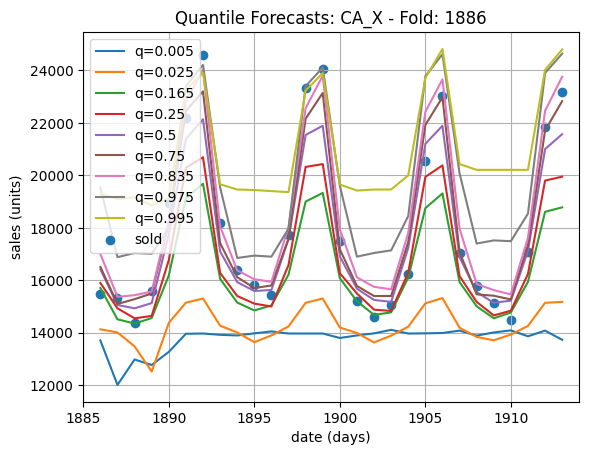

2023-12-03 23:25:06 - __main__ - INFO - TX_X


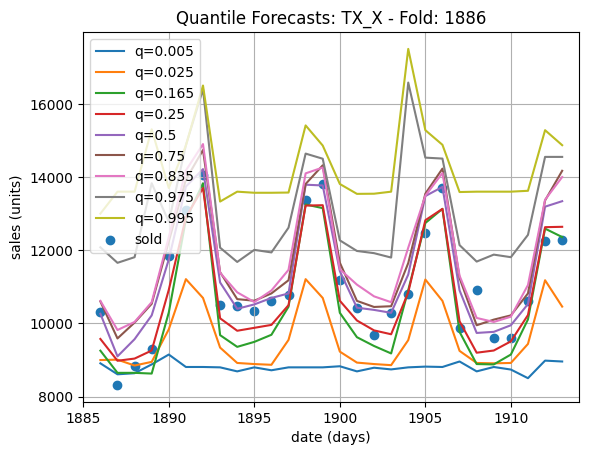

2023-12-03 23:25:06 - __main__ - INFO - Total_X


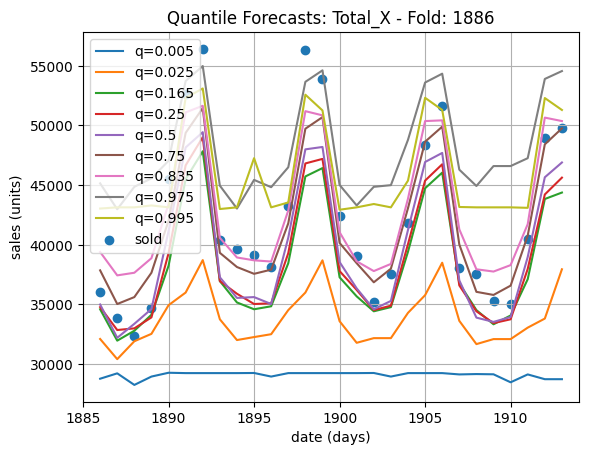

2023-12-03 23:25:07 - __main__ - INFO - WI_X


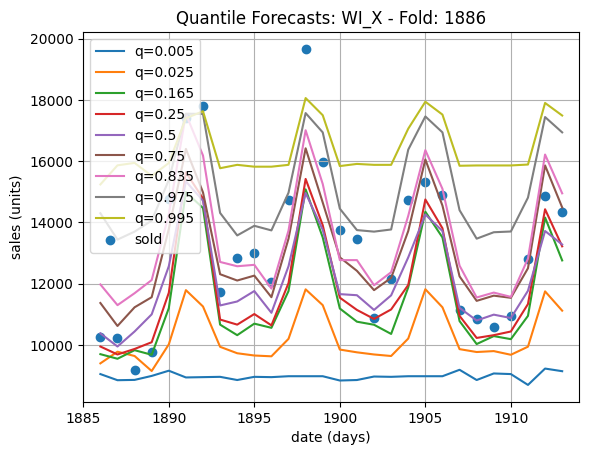

In [67]:
for group, df_temp in rrr.groupby('id_merge'):
    logger.info(group)
    
    # plot 
    for quantile in df_temp['quantile'].unique():
        df_temp[df_temp['quantile'] == quantile]['pred'].plot(label = f'q={quantile}')
        
    # plot actual sales
    idx = df_temp['quantile'] == quantile
    plt.scatter(df_temp[idx].index, df_temp[idx]['sold'], label = f'sold')
    
    # nice graph
    plt.xlim(FOLD-1, FOLD+DAYS)
    plt.grid()
    plt.legend()
    
    plt.title(f'Quantile Forecasts: {group} - Fold: {FOLD}')
    plt.xlabel('date (days)')
    plt.ylabel('sales (units)')
    plt.savefig(f'../figure/results/forecast_{experiment_name}_{"_".join(INCLUDE_COLUMNS)}_{group}_{fold}.png', dpi = 300)
    plt.show()

### Load WSPL Scores

In [18]:
experiment_name = 'seasonal'
experiment_name = 'best models'
BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]

In [19]:
from utils.utils import load_results_as_json

In [23]:
def print_experiment_results(experiment_name, use_all: bool = False, return_table: bool = False):
    if not use_all:
        BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
        INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
        INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]
    
    # load json where all results are stored
    r = load_results_as_json('../data/uncertainty/all_results.json')

    ### create dataframe with all results
    r_all_folds = []
    r_ind_folds = []
    for features_def, results_all_folds in r.items():
        if not use_all:
            if features_def not in ['include_' + ' '.join(i) for i in INCLUDE_COLUMNS_LIST]:
                # print(features_def)
                # print(['_'.join(i) for i in INCLUDE_COLUMNS_LIST])
                continue
        features_global_sum = 0
        i = 0
        for fold, fold_results in results_all_folds.items():
            features_fold_sum = 0
            j = 0
            for level, wspl in fold_results.items():
                features_fold_sum += wspl
                j += 1
                features_global_sum += wspl
                i += 1
            r_ind_folds.append([features_def.removeprefix('include_'), fold, features_fold_sum / j, j])
        r_all_folds.append([features_def.removeprefix('include_'), features_global_sum / i])
        
    df_per_fold = pd.DataFrame(r_ind_folds, columns=['features', 'fold', 'avg_wspl', 'n_levels'])
    df_per_fold

    df_all = df_per_fold.groupby('features')['avg_wspl'].agg([np.average, np.std])
    df_all = df_all.sort_values('average')
    
    # only store table for specific experiments
    if not use_all:
        table_name = experiment_name.replace(' ', '_')
        table_name = experiment_name.replace('/', '_')
        df_all.to_latex(f'../data/uncertainty/tables/{table_name}.tex')
    logger.info(f'----------- experiment: {experiment_name} -----------')
    logger.info('\n' + str(df_all.sort_values('average')))
    if use_all or return_table:
        return df_all

In [24]:
### ALL EXPERIMENTS
all_experiments = list(EXPERIMENTS_DICT.keys())
print(f'All experiments:\n{all_experiments}')
for experiment_name in all_experiments:
    print_experiment_results(experiment_name)

2023-12-03 19:40:37 - __main__ - INFO - ----------- experiment: seasonal -----------
2023-12-03 19:40:37 - __main__ - INFO - 
                                                   average       std
features                                                            
seasonal auto_sold_ewm                            0.201925  0.029461
seasonal_weekday seasonal_monthday auto_sold_ewm  0.202562  0.032922
seasonal_weekday auto_sold_ewm                    0.214894  0.025278
seasonal_monthday auto_sold_ewm                   0.305850  0.021330
auto_sold_ewm                                     0.310573  0.016042
2023-12-03 19:40:37 - __main__ - INFO - ----------- experiment: ewm vs. ma -----------
2023-12-03 19:40:37 - __main__ - INFO - 
Empty DataFrame
Columns: [average, std]
Index: []
2023-12-03 19:40:37 - __main__ - INFO - ----------- experiment: quantiles vs. std -----------
2023-12-03 19:40:37 - __main__ - INFO - 
Empty DataFrame
Columns: [average, std]
Index: []
2023-12-03 19:40:37 - __main

2023-12-03 19:40:37 - __main__ - INFO - 
Empty DataFrame
Columns: [average, std]
Index: []
2023-12-03 19:40:37 - __main__ - INFO - ----------- experiment: best models -----------
2023-12-03 19:40:37 - __main__ - INFO - 
Empty DataFrame
Columns: [average, std]
Index: []
2023-12-03 19:40:37 - __main__ - INFO - ----------- experiment: full vs. sparse -----------
2023-12-03 19:40:37 - __main__ - INFO - 
                                                     average       std
features                                                              
seasonal auto_sold_ma auto_sold_std auto_sold_q...  0.190950  0.026925
seasonal auto_sold_ewm_112 auto_sold_ewm_28 aut...  0.195578  0.037068


All experiments:
['seasonal', 'ewm vs. ma', 'quantiles vs. std', 'price auto/momentum', 'best models', 'full vs. sparse']
